# Example 4: Model Training
First we import the necessary modules

In [91]:
import torch
from math import sqrt
from torch.utils.data import DataLoader
from pythermondt import transforms as T
from pythermondt.data import ThermoDataset, DataContainer, random_split
from pythermondt.readers import S3Reader
from example_models.defect_classifier import DefectClassifier3DCNN, Small3DCNN

First we define some general parameters for the model training

In [92]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set global random seed for reproducibility
torch.manual_seed(42)

# Model Hyperparameters
epochs = 5
batch_size_scaler = 4
batch_size = 32
learning_rate = 1e-4 * sqrt(batch_size_scaler) # Scale with sqrt rule, according to this: https://stackoverflow.com/a/66546571

Now we can the define all the datasources used for training. Here you could specify multiple datasources (which are later combined using the dataset) if you need that. In this example we only use one datasource.

**Note:** For the S3Reader object we set the cache_files flag to true. Therefore all the files are cached to a folder (.pyThermoNDT_cache) in the current working directory. This makes training way faster, because the files are now only downloaded once and not every time the datasource is loaded. 

In [93]:
folder = "sanity_checked/noise_level0.025 confidence0.5"
base_path = "s3://ffg-bp/SAL-Dataset/" + folder
# Specifiy the datasource
no_defect = S3Reader(
    source=base_path + "/no_defect/.hdf5",
    cache_files=True,
    num_files=2500
)

visible = S3Reader(
    source=base_path + "/defect_visible/.hdf5",
    cache_files=True,
    num_files = 2500
)

Now we can combine these datasources by creating a dataset.

In [94]:
# Create a Dataset
dataset = ThermoDataset(data_source=[no_defect, visible])

Afterwards the transform pipeline which will be applied to the data before it gets fed into the model is defined. In this example we use Data Augmentation techniques like flipping and rotating the images or adding noise to the images (to simulate NETD of the camera). Therefore we need 2 different pipelines. One for the training set and one for the test set.

In [95]:
# Setup transform pipeline for training set
train_pipeline = T.Compose([
    T.ApplyLUT(),
    T.GaussianNoise(std=25e-3), # Data Augmentation
    T.RandomFlip(p_height=0.3, p_width=0.3), # Data Augmentation
    T.SubtractFrame(0), 
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(32),
    T.MinMaxNormalize(),
])

# Setup transform pipeline for test set
test_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0), 
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(32),
    T.MinMaxNormalize(),
])

Before we can continue, we first need to write a custom collate function. All our readers and datasets always load data in form of Datacontainer objects. However, when training a model the input data needs to be in form of a tensor. Therefore the collate function extracts the data from all the Datacontainer objects in the current batch and stacks them along the batch dimension:

In [96]:
# Custom collate function to extract data and target from the DataContainers in the batch
def collate_fn(batch: list[DataContainer]) -> tuple[torch.Tensor, torch.Tensor]:
    # Extract data and target from the DataContainers
    tdata = []
    mask = []

    # Extract the data and label from the DataContainer
    for container in batch:
        tdata.append(container.get_dataset("/Data/Tdata").unsqueeze(0)) # Extract data and add channel dimension
        mask.append(0 if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else 1)

    # Stack the tensors along the batch dimension
    data = torch.stack(tdata).to(device=device, dtype=torch.float32)
    label = torch.tensor(mask, device=device, dtype=torch.long)

    return data, label

Next we can split the dataset into a training and validation subset, using the random_split function provided with pyThermoNDT. Afterwards the dataloaders for each of the subsets are created.

In [97]:
# Split the dataset in train and test subsets
train_set, test_set = random_split(dataset, [0.8, 0.2], [train_pipeline, test_pipeline])

# Print the length of the subsets
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

# Create a DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Train set length: 629
Test set length: 157


In [98]:
def check_if_defect_free(container: DataContainer) -> bool:
    par = container.get_attribute("/MetaData", "SimulationParameter")
    if isinstance(par, list):
        names = [x[0] for x in par]
        values = [x[3] for x in par]

        # Get index of shape in names
        idx = names.index("shape")
        shape = values[idx]
        
        # shape == 1 ==> defect free
        if shape == 1:
            return True
    return False

defect_free = 0
defect = 0
for i, container in enumerate(train_set):
    if check_if_defect_free(container):
        defect_free += 1
    else:
        defect += 1

print(f"In train_set ==> defect: {defect}, defect_free: {defect_free}")

defect_free = 0
defect = 0
for container in test_set:
    result = check_if_defect_free(container)

    if result:
        defect_free += 1
    else:
        defect += 1

print(f"In test_set ==> defect: {defect}, defect_free: {defect_free}")

In train_set ==> defect: 140, defect_free: 489
In test_set ==> defect: 41, defect_free: 116


Now lets verify that the loaders load the data with the correct dimensionality. The models expects the data in **B x C x H x W x T**:
* B ... Batchsize
* C ... Channels
* H / W ... Height / Width
* T ... Time dimension

In [99]:
for data, label in train_loader:
    print("Data Shape: ", data.shape)
    print("Label Shape: ", label.shape)
    break

Data Shape:  torch.Size([32, 1, 100, 100, 32])
Label Shape:  torch.Size([32])


Now that we have defined all the transform pipelines, lets also verify that the input to the model is correct. Lets plot some images from the training set and test set to see if the transformations are applied correctly.

no-defect


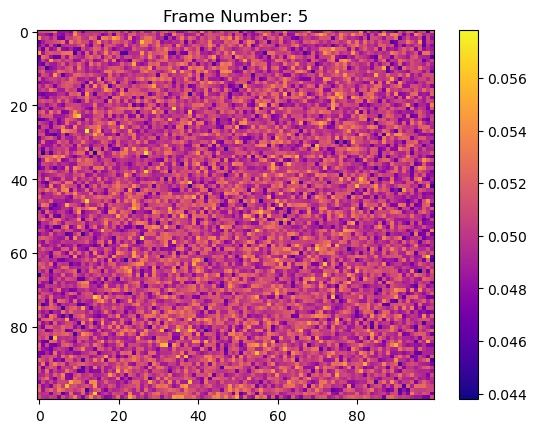

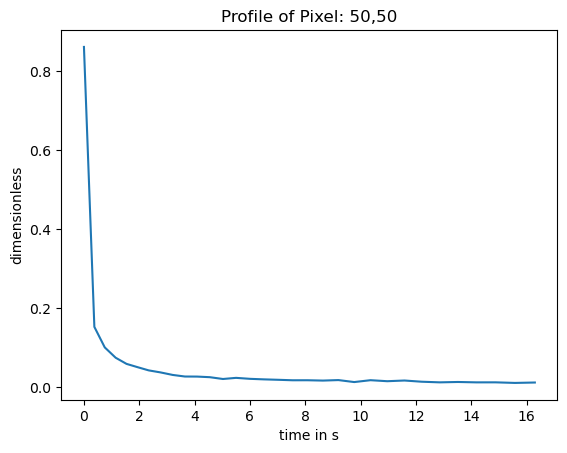

no-defect


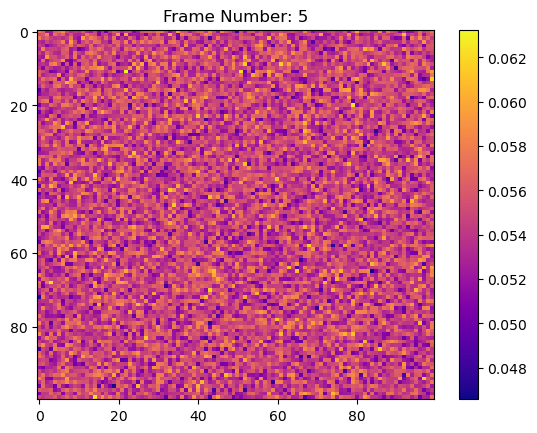

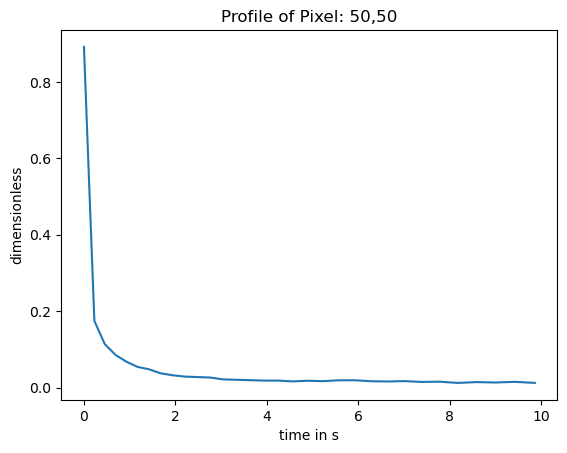

In [100]:
# Visualize the data input
# Visualize a no-defect sample
container = train_set[1]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

# Visualize a defect sample
container = train_set[2]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

Before we can start the training we also need to define the model, the loss function and the optimizer:

In [101]:
# Define the model and optimizer
model = DefectClassifier3DCNN(time_dim=32).to(device)
# model = Small3DCNN(time_dim=32, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

Now we can run the training loop with the following code. The training loop is very simple and only consists of a few lines of code. For real world applications you might want to add more features like logging, early stopping, learning rate scheduling, etc.

In [102]:
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # Set the model to training mode
    model.train()
    print("Training:")
    for batch_idx, (data, label) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss
        print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Evaluate the model
    with torch.no_grad():
        model.eval()
        val_loss_summed = 0
        print("Validation:")
        for batch_idx, (data, label) in enumerate(val_loader):
            # Forward pass
            output = model(data)

            # Compute the loss
            loss = loss_fn(output, label)
            val_loss_summed += loss.item()
        
        print(f"Validation Loss: {val_loss_summed / len(val_loader)}")

Epoch 0
Training:
Batch 0, Loss: 0.6738956570625305
Batch 1, Loss: 0.6330503821372986
Batch 2, Loss: 0.6563773155212402
Batch 3, Loss: 0.5736117959022522
Batch 4, Loss: 0.6434618234634399
Batch 5, Loss: 0.5569515228271484
Batch 6, Loss: 0.7022703886032104
Batch 7, Loss: 0.3938024342060089
Batch 8, Loss: 0.6101112365722656
Batch 9, Loss: 0.4751274287700653
Batch 10, Loss: 0.4868850111961365
Batch 11, Loss: 0.5584638714790344
Batch 12, Loss: 0.4342244863510132
Batch 13, Loss: 0.38727110624313354
Batch 14, Loss: 0.2971908748149872
Batch 15, Loss: 0.3703499436378479
Batch 16, Loss: 0.43603816628456116
Batch 17, Loss: 0.32524365186691284
Batch 18, Loss: 0.5507360100746155
Batch 19, Loss: 0.5953518152236938
Batch 20, Loss: 0.6262875199317932
Batch 21, Loss: 0.7584541440010071
Batch 22, Loss: 0.7221570611000061
Batch 23, Loss: 0.6461219787597656
Batch 24, Loss: 0.4182579815387726
Batch 25, Loss: 0.6053697466850281
Batch 26, Loss: 0.4855807423591614
Batch 27, Loss: 0.42633527517318726
Batch 28

KeyError: "Node at path '/MetaData/LookUpTable' does not exist."